In [1]:
import pandas as pd

#Считывание данных

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train.csv")

Вспомним, как выглядел датасет

In [3]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.25,NaN,S
470,471,0,3,"Keefe, Mr. Arthur",male,NaN,0,0,323592,7.25,NaN,S
782,783,0,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.00,D6,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.50,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.90,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


##Предобработка датасета

Для будущей модели важны только данные, которые можно представить в виде чисел. Исключением будет столбец с полом, для него введем обозначения: 1 = male, 0 = female. Кроме того, столбец с PassengerId не имеет смысла - это просто индекс.

In [5]:
df.loc[df['Sex'] == 'male', 'Sex'] = 1
df.loc[df['Sex'] == 'female', 'Sex'] = 0

In [6]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
714,715,0,2,"Greenberg, Mr. Samuel",1,52.0,0,0,250647,13.0000,NaN,S
400,401,1,3,"Niskanen, Mr. Juha",1,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",0,62.0,0,0,113572,80.0000,B28,NaN
464,465,0,3,"Maisner, Mr. Simon",1,NaN,0,0,A/S 2816,8.0500,NaN,S
410,411,0,3,"Sdycoff, Mr. Todor",1,NaN,0,0,349222,7.8958,NaN,S


In [7]:
df_to_model = df.drop(labels=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)

In [8]:
df_to_model.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,1,22.0,1,0,7.2500
1,1,1,0,38.0,1,0,71.2833
2,1,3,0,26.0,0,0,7.9250
3,1,1,0,35.0,1,0,53.1000
4,0,3,1,35.0,0,0,8.0500


В столбце возраст присутствуют пропущенные значения.

In [9]:
100 * df_to_model['Age'].isna().sum() / df_to_model.shape[0]

19.865319865319865

Почти 20% данных отсуствует, заменим на медианное значение.

In [10]:
median_age = df_to_model['Age'].median()
median_age

28.0

In [11]:
df_to_model.fillna({'Age': median_age}, inplace=True)

In [12]:
df_to_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.9+ KB


Создадим x - датасет со всеми данными, кроме ответов (Survived) и y - столбец с данными о выживаемости.

In [13]:
x = df_to_model.drop(labels='Survived', axis=1)
x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,1,22.0,1,0,7.2500
1,1,0,38.0,1,0,71.2833
2,3,0,26.0,0,0,7.9250
3,1,0,35.0,1,0,53.1000
4,3,1,35.0,0,0,8.0500


In [14]:
y = df_to_model['Survived']
y.head()

,Survived
0,0
1,1
2,1
3,1
4,0


##Тренировочный и тестовый датасеты

Разобьем полученные x и y на тренировочный и тестовый датасеты.

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    random_state=2024,
                                                    test_size=0.25)

#Обоснование метрики

Метриками в задаче классификации являются: <br><b>accuracy</b>: самая простая метрика, плохо работает при дисбалансе классов;
<br><b>precision&recall</b>: обе лучше работают при дисбалансе классов. Точность полезнее, когда важно избежать false positives результатов. Полнота полезнее, когда важно выявить как можно больше положительных результатов;
<br><b>F-мера</b>: комбинация двух предыдущих, удобнее, так как совмещает две метрики. Можно контролировать вес precision и recall.

Проверим дисбаланс классов в изначальном датасете (процент выживаемости)

In [17]:
print(f"Процент выживших: {df['Survived'].mean() * 100:.2f}%")

Процент выживших: 38.38%


Дисбаланс классов в исходном датасете примерно 60 на 40, при этом разбитие на тестовый и тренировочный датасеты не учитывало никакого дисбаланса, так что неизвестно, какой он получился в них. Исходя из этого сразу отметаем метрику accuracy. В данной задаче важно избегать ложно положительных результатов (когда человек по предсказанию выжил, а фактически нет), при этом также важен и поиск действительно положительных результатов (пассажир выжил). Из этого всего можно сделать вывод, что в задаче одинаково важны и precision и recall, значит <b>воспользуемся F1 мерой</b>.

#Построение baseline и ML-модели

In [18]:
from sklearn.dummy import DummyClassifier # Создание baseline
from sklearn.linear_model import LogisticRegression # Модель

Пускай классификатор всегла возвращает наиболее частое значение.

In [19]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(x_train, y_train)

DummyClassifier(strategy='most_frequent')

Создание модели и обучение методом fit.

In [20]:
log_reg = LogisticRegression(random_state=2024)
log_reg.fit(x_train, y_train)

LogisticRegression(random_state=2024)

In [21]:
y_pred_dummy = dummy_clf.predict(x_test)
y_pred_log_rec = log_reg.predict(x_test)

In [22]:
from sklearn.metrics import f1_score

In [23]:
print(f"F1 score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}")
print(f"F1 score for Logistic Regression: {f1_score(y_test, y_pred_log_rec)}")

F1 score for Dummy Classificator: 0.0
F1 score for Logistic Regression: 0.73224043715847


Точность модели всего 73%. Попробуем поменять порог классификации.

In [24]:
from sklearn.metrics import precision_recall_curve

In [25]:
import matplotlib.pyplot as plt

In [26]:
import numpy as np

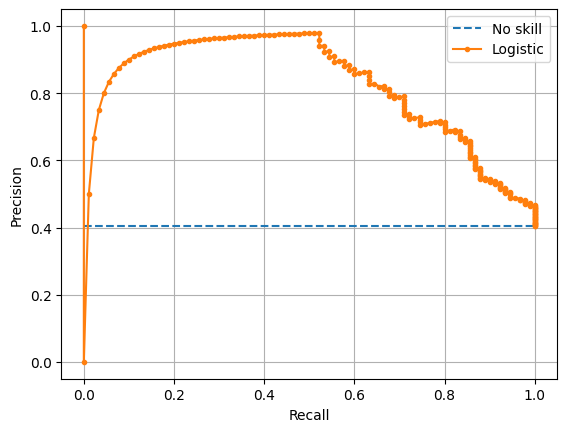

In [27]:
y_pred = log_reg.predict_proba(x_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
no_skill = len(y_test[y_test == 1]) / len(y_test)

plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid()
plt.show()

Найдем максимум для precision и recall

In [28]:
def find_second_largest(numbers):
    return sorted(set(numbers))[-2]

In [29]:
np.where(precision==find_second_largest(precision))[0]

array([166])

In [30]:
y_pred_new_threshold = (log_reg.predict_proba(x_test)[:, 1] >= thresholds[166]).astype(int)

In [31]:
print(f"F1 score for Dummy Classificator: {f1_score(y_test, y_pred_dummy)}")
print(f"F1 score for Logistic Regression: {f1_score(y_test, y_pred_new_threshold)}")

F1 score for Dummy Classificator: 0.0
F1 score for Logistic Regression: 0.6811594202898551


Ситуация не улучшилась.